# Import modules

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from google.colab import files as filescolab

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


# Model PINN

In [4]:
class simpleModel(nn.Module):
  def __init__(self,
               hidden_size=20):
    super().__init__()
    self.layers_stack = nn.Sequential(
        nn.Linear(1, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size), #1
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size), #2
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size), #3
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size), #4
        nn.Tanh(),
        nn.Linear(hidden_size, 1),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.layers_stack(x)

# Enter your data or or use another method to save history

# PDE of the motion of harmonic oscillator

In [5]:
# def pde(out, t, nu=2):
#     omega = 2 * torch.pi * nu
#     dxdt = torch.autograd.grad(out, t, torch.ones_like(t), create_graph=True, \
#                             retain_graph=True)[0]
#     d2xdt2 = torch.autograd.grad(dxdt, t, torch.ones_like(t), create_graph=True, \
#                             retain_graph=True)[0]
#     f = d2xdt2 + (omega ** 2) * out
#     return f

def pde(out, x, C=1):
    du_dx = torch.autograd.grad(out, x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]

    f = C * x

    residual = d2u_dx2 + f
    return residual



In [6]:
# nu=2
# omega = 2 * torch.pi * nu
# x0_true=torch.tensor([1], dtype=float).float().to(device)
# dx0dt_true=torch.tensor([0], dtype=float).float().to(device)
C = 1.0
T_star = 1.0
u_star = 1.0
L = 10.0
x0_true=torch.tensor([-T_star], dtype=float).float().to(device)
dx0dt_true=torch.tensor([u_star], dtype=float).float().to(device)

#Training

In [7]:
def pdeBC(t):
    out = model(t).to(device)
    f1 = pde(out, t)

    inlet_mask = (t[:, 0] == 0)
    t0 = t[inlet_mask]
    x0 = model(t0).to(device)
    dx0dt = torch.autograd.grad(x0, t0, torch.ones_like(t0), create_graph=True, \
                        retain_graph=True)[0]

    loss_bc = metric_data(x0, x0_true) + \
                metric_data(dx0dt, dx0dt_true.to(device))
    loss_pde = metric_data(f1, torch.zeros_like(f1))

    loss = 1e3*loss_bc + loss_pde

    # metric_x = metric_data(out, x0_true * torch.sin(omega*t + torch.pi / 2))
    # metric_x0 = metric_data(x0, x0_true)
    # metric_dx0dt = metric_data(dx0dt, dx0dt_true.to(device))

    # acc_metrics = {'metric_x': metric_x,
    #             'metric_x0': metric_x0,
    #             'metric_dx0dt': metric_dx0dt,
    #             }

    # metrics = {'loss': loss,
    #             'loss_bc': loss_bc,
    #             'loss_pde': loss_pde,
    #             }

    return loss

In [8]:
model = simpleModel().to(device)

In [9]:
steps=1000
pbar = tqdm(range(steps), desc='Training Progress')
t = (torch.linspace(0, 1, 100).unsqueeze(1)).to(device)
t.requires_grad = True

metric_data = nn.MSELoss()
writer = SummaryWriter()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)

def train():


    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pdeBC(t)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.6f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)

train()
writer.close()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Step: 998 | Loss: 5000.334961: 100%|██████████| 1000/1000 [00:49<00:00, 20.36it/s]


# Save weights

In [11]:
torch.save(model.state_dict(), 'weights_PINN_harm_oscil_3exp.pth')
filescolab.download("weights_PINN_harm_oscil_3exp.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load weights (if necessary)

In [ ]:
path='/content/weights_PINN_harm_oscil_3exp.pth'

model.load_state_dict(torch.load(path,\
                                 map_location=torch.device('cpu')))

# Predict values

In [13]:
t = torch.linspace(0, 1, 100).unsqueeze(-1).unsqueeze(0).to(device)
t.requires_grad=True
x_pred = model(t.float())

In [14]:
# x_true = x0_true * torch.cos(omega*t)
x_true = C/6 *(L**3 - t**3) - T_star*(t+L) + u_star

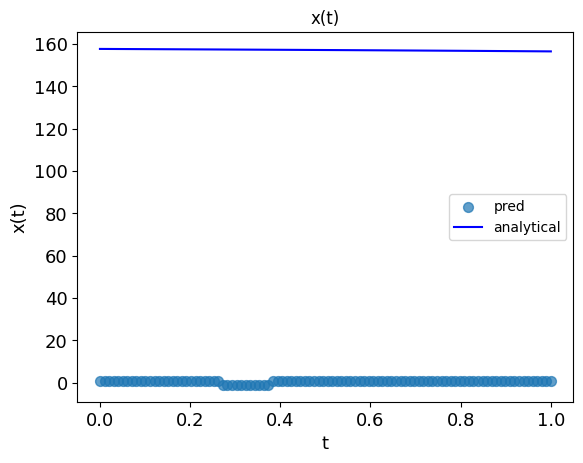

In [15]:
fs=13
plt.scatter(t[0].cpu().detach().numpy(), x_pred[0].cpu().detach().numpy(), label='pred',
            marker='o',
            alpha=.7,
            s=50)
plt.plot(t[0].cpu().detach().numpy(),x_true[0].cpu().detach().numpy(),
         color='blue',
         label='analytical')
plt.xlabel('t', fontsize=fs)
plt.ylabel('x(t)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend()
plt.title('x(t)')
plt.savefig('x.png')
plt.show()

In [ ]:
dxdt = torch.autograd.grad(x_pred, t, torch.ones_like(t), create_graph=True, \
                    retain_graph=True)[0]
dxdt = dxdt.cpu().detach().numpy()[0]

In [ ]:
dxdt_true = -x0_true*omega * torch.sin(omega*t)

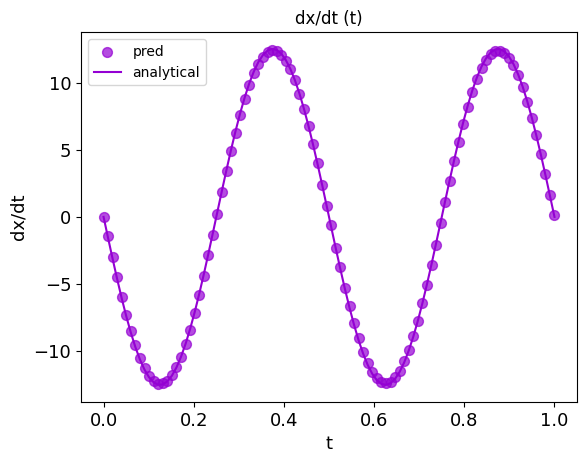

In [ ]:
plt.scatter(t[0].cpu().detach().numpy(), dxdt, label='pred',
            marker='o',
            alpha=.7,
            s=50,
            color='darkviolet')
plt.plot(t[0].cpu().detach().numpy(),dxdt_true[0].cpu().detach().numpy(),
         color='darkviolet',
         label='analytical')
plt.xlabel('t', fontsize=fs)
plt.ylabel('dx/dt', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend()
plt.title('dx/dt (t)')
plt.savefig('dxdt.png')
plt.show()

# history

In [ ]:
path='/content/loss_pde.csv'
loss_pde=np.genfromtxt(path, delimiter=',')[:, 2]

path='/content/loss_bc.csv'
loss_bc=np.genfromtxt(path, delimiter=',')[:, 2]

path='/content/loss.csv'
total_loss=np.genfromtxt(path, delimiter=',')[:, 2]

In [ ]:
fs = 12

plt.plot(loss_pde, label=r'$Loss_{PDE}$')
plt.plot(1e3*loss_bc, label=r'$\lambda_{BC}Loss_{BC}$')
plt.plot(total_loss, label=r'$Loss_{sum}$')

ax=plt.gca()
ax.set_yscale('log')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle='--')
plt.xlim(0, 2e4)
plt.ylim(1e-1, 1e3)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.tick_params(axis='both',direction='in')

plt.legend(fontsize=fs)
plt.xlabel('Iteration count', fontsize=fs)
plt.ylabel('Loss', fontsize=fs)
plt.title('Loss while training')
plt.tight_layout()
plt.savefig('history_harm.png')
plt.show()